In [1]:
import os
import json
from pathlib import Path
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt


from data import get_dataset, get_zoo_elephants_images_and_labels, get_ELEP_images_and_labels, parse_image_function
from train import SiameseModel


import tensorflow as tf

In [2]:
with open('hyperparameters/initial_run.json', 'rb') as f:
    params = json.load(f)

In [3]:
data_dir = '/Users/deepakduggirala/Documents/ELPephant-cropped'

In [5]:
cache_files = {
        'train': str(Path(data_dir) / 'train.cache'),
        'val': str(Path(data_dir) / 'val.cache')
    }

In [5]:
# mode = 'train'
# image_paths, image_labels = get_ELEP_images_and_labels(Path(data_dir)/mode)
# N = len(image_labels)

# AUTOTUNE = tf.data.AUTOTUNE
# dataset = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))
# dataset = dataset.shuffle(buffer_size=N)
# dataset = dataset.map(lambda x, y: (parse_image_function(
#         x, params['image_size']), y), num_parallel_calls=AUTOTUNE)
# dataset = dataset.cache(cache_files[mode])
# dataset = dataset.batch(params['batch_size']).prefetch(AUTOTUNE)

In [6]:
train_ds, N_train = get_dataset(get_ELEP_images_and_labels, params, data_dir, 'train', cache_files)

reading Tensor("args_0:0", shape=(), dtype=string)


In [7]:
%%time
s = set()
i=0
for images, labels in train_ds.as_numpy_iterator():
    print(i, labels.shape)
    print('new labels', len(set(labels)-s))
    s.update(set(labels))
    i=i+1

2022-04-22 02:10:18.568194: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-22 02:10:28.587355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1061 of 1618
2022-04-22 02:10:34.335349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.
2022-04-22 02:10:34.411569: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0 (128,)
new labels 89
1 (128,)
new labels 43
2 (128,)
new labels 35
3 (128,)
new labels 19
4 (128,)
new labels 15
5 (128,)
new labels 7
6 (128,)
new labels 3
7 (128,)
new labels 1
8 (128,)
new labels 2
9 (128,)
new labels 0
10 (128,)
new labels 0
11 (128,)
new labels 0
12 (82,)
new labels 0
CPU times: user 30.2 s, sys: 3.02 s, total: 33.2 s
Wall time: 16.4 s


In [8]:
len(s)

214

In [6]:
val_ds, _, N_val = get_dataset(get_ELEP_images_and_labels, params, data_dir, 'val', cache_files)

reading Tensor("args_0:0", shape=(), dtype=string)


In [10]:
images, labels = next(val_ds.as_numpy_iterator())
labels.shape

(457,)

In [11]:
len(set(labels))

60

In [21]:
mode = 'train'
image_paths, image_labels = get_ELEP_images_and_labels(Path(data_dir)/mode)
N = len(image_labels)

AUTOTUNE = tf.data.AUTOTUNE
dataset = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))
# dataset = dataset.shuffle(buffer_size=N)
dataset = dataset.map(lambda x, y: (parse_image_function(
        x, params['image_size']), y), num_parallel_calls=AUTOTUNE)
dataset = dataset.cache(cache_files[mode])
dataset = dataset.shuffle(buffer_size=N)
dataset = dataset.batch(params['batch_size']).prefetch(AUTOTUNE)

reading Tensor("args_0:0", shape=(), dtype=string)


In [22]:
images, labels = next(dataset.as_numpy_iterator())
labels

array([b'1578', b'2559', b'3898', b'4249', b'3470', b'2350', b'2655',
       b'264', b'4169', b'3746', b'2090', b'638', b'2651', b'4246',
       b'2674', b'3012', b'3897', b'1732', b'1437', b'1319', b'1997',
       b'3999', b'951', b'52', b'3372', b'3898', b'1009', b'1211',
       b'2353', b'3412', b'1287', b'1123', b'3441', b'3012', b'637',
       b'3252', b'1566', b'1566', b'183', b'2651', b'2559', b'1888',
       b'373', b'2241', b'3409', b'42', b'568', b'5160', b'2841', b'1319',
       b'3346', b'15', b'3252', b'373', b'1876', b'4031', b'2350',
       b'2380', b'520', b'520', b'3470', b'1436', b'2723', b'1234',
       b'843', b'1186', b'3410', b'3384', b'1123', b'565', b'2779',
       b'3898', b'3999', b'1577', b'654', b'251', b'3410', b'3746',
       b'1370', b'459', b'3809', b'3901', b'1411', b'1439', b'5259',
       b'284', b'3766', b'4031', b'15', b'2602', b'567', b'818', b'145',
       b'3062', b'1673', b'2651', b'4031', b'4109', b'5137', b'2380',
       b'3756', b'3346', b'35

from collections import Counter

ids = np.arange(274)
np.random.shuffle(ids)
val_ids = ids[:60]

sorted_unique_labels = sorted(set(image_labels))
c = Counter(sorted(image_labels))
sum([c[sorted_unique_labels[i]] for i in val_ids])

data_dir

val_dir = Path(data_dir) / 'val'

val_class_ids = [sorted_unique_labels[i] for i in val_ids]

val_files = [i for i in Path(data_dir).iterdir() if i.suffix in ['.jpg'] and i.name.split('_')[0] in val_class_ids]

len(val_files)

val_dir.mkdir()

for src in val_files:
    target = val_dir / src.name
    src.replace(target)

In [83]:
image_path = '/Users/deepakduggirala/Documents/ELPephant-cropped/train/1002_Cynthia I front_7Mar2015.jpg'
image_string = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image_string, channels=3)

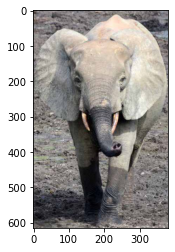

In [84]:
plt.imshow(image.numpy())

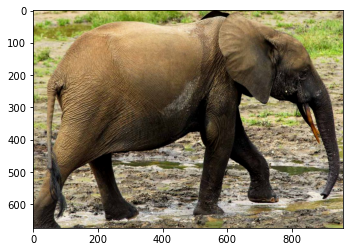

In [64]:
new_image = tf.image.random_brightness(image, 0.2)
plt.imshow(new_image.numpy().astype(np.uint8))

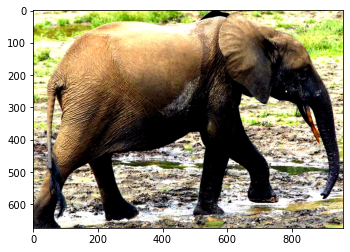

In [67]:
new_image = tf.image.random_contrast(image, 0.5, 2.0)
plt.imshow(new_image.numpy().astype(np.uint8))

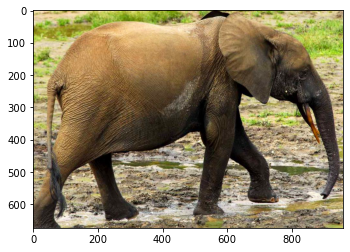

In [54]:
new_image = tf.image.random_saturation(image, 0.75, 1.25)
plt.imshow(new_image.numpy().astype(np.uint8))

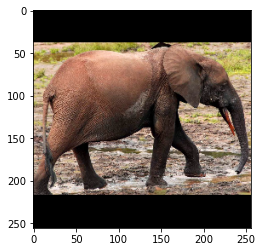

In [78]:
new_image = tf.image.random_hue(bbb, 0.1)
plt.imshow(new_image.numpy().astype(np.uint8))

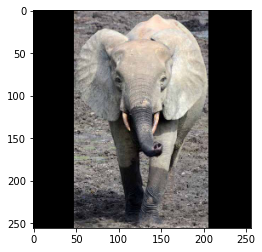

In [85]:
new_image2 = tf.image.resize_with_pad(image, target_height=256, target_width=256, )
plt.imshow(new_image2.numpy().astype(np.uint8))

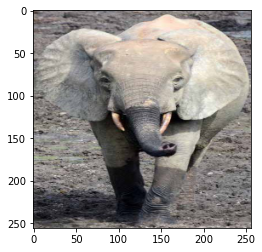

In [86]:
new_image = tf.image.resize(image, [256, 256])
plt.imshow(new_image.numpy().astype(np.uint8))

In [72]:
new_image

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[245.375   , 224.70166 , 175.9414  ],
        [250.65332 , 229.18408 , 186.59473 ],
        [250.60986 , 227.52832 , 193.17627 ],
        ...,
        [199.48584 , 179.61084 , 146.73584 ],
        [196.33887 , 179.33887 , 149.33887 ],
        [212.28809 , 197.67578 , 170.98193 ]],

       [[243.72998 , 226.1792  , 181.07764 ],
        [246.91504 , 228.81348 , 185.88232 ],
        [249.27197 , 231.17041 , 189.82275 ],
        ...,
        [176.88428 , 157.88428 , 125.00928 ],
        [195.89355 , 176.89355 , 146.89355 ],
        [208.85889 , 189.6128  , 164.51123 ]],

       [[244.9956  , 232.15967 , 188.07764 ],
        [240.49365 , 227.66797 , 182.55518 ],
        [241.88525 , 230.04932 , 181.80322 ],
        ...,
        [174.6709  , 158.2959  , 124.5459  ],
        [175.73193 , 154.73193 , 125.73193 ],
        [190.70264 , 165.39111 , 142.04688 ]],

       ...,

       [[ 90.76953 ,  81.76953 ,  76.76953 ],
        [ 87.